# Completing forwards simulations

:::{note}
Link to other tutorial sections on forward sims
:::

The ``msprime`` simulator generates tree sequences using the backwards in
time coalescent model. But it is also possible to output tree sequences
from [forwards-time](https://doi.org/10.1371/journal.pcbi.1006581)
simulators such as [SLiM](https://messerlab.org/slim)
and [fwdpy11](https://fwdpy11.readthedocs.io/).
There are many advantages to using forward-time simulators, but they
are usually quite slow compared to similar coalescent simulations. In this
section we show how to combine the best of both approaches by simulating
the recent past using a forwards-time simulator and then complete the
simulation of the ancient past using ``msprime``. (We sometimes refer to this
"recapitation", as we can think of it as adding a "head" onto a tree sequence.)

First, we define a simple Wright-Fisher simulator which returns a tree sequence
with the properties that we require (please see the 
{ref}`msprime documentation <msprime:sec_ancestry_initial_state>`
for a formal description of these properties):

In [1]:
import tskit
import msprime
import random
import numpy as np
from IPython.display import SVG


def wright_fisher(N, T, L=100, random_seed=None):
    """
    Simulate a Wright-Fisher population of N haploid individuals with L
    discrete loci for T generations. Based on Algorithm W from
    https://doi.org/10.1371/journal.pcbi.1006581
    """
    random.seed(random_seed)
    tables = tskit.TableCollection(L)
    tables.populations.add_row()
    P = np.arange(N, dtype=int)
    for _ in range(N):
        tables.nodes.add_row(time=T, flags=0, population=0)
    t = T
    while t > 0:
        t -= 1
        Pp = P.copy()
        for j in range(N):
            u = tables.nodes.add_row(time=t, flags=0, population=0)
            Pp[j] = u
            a = random.randint(0, N - 1)
            b = random.randint(0, N - 1)
            x = random.randint(1, L - 1)
            tables.edges.add_row(0, x, P[a], u)
            tables.edges.add_row(x, L, P[b], u)
        P = Pp

    # Now do some table manipulations to ensure that the tree sequence
    # that we output has the form that msprime needs to finish the
    # simulation. (Note: table columns are not modified in place because the
    # tables API does not currently allow direct access to memory.)

    # Mark the extant population as samples.
    flags = tables.nodes.flags
    flags[P] = tskit.NODE_IS_SAMPLE
    tables.nodes.flags = flags
    tables.sort()
    # Simplify with respect to the current generation, but ensuring we keep the
    # ancient nodes from the initial population.
    tables.simplify(keep_input_roots=True)
    return tables.tree_sequence()

We then run a tiny forward simulation of 10 two-locus individuals
for 5 generations, and print out the resulting trees:

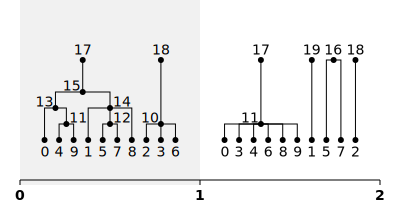

In [2]:
num_loci = 2
N = 10
wf_ts = wright_fisher(N, 5, L=num_loci, random_seed=3)
SVG(wf_ts.draw_svg())

Because our Wright Fisher simulation ran for only 5 generations, there has not
been enough time for the trees to fully coalesce. Therefore, instead of having
one root, the trees have several --- the first tree has 2 and the second 4.
Nodes 16, 17, 18, and 19 in this simulation represent the members of the
initial population of the simulation that have genetic descendants at the end
of the simulation. These unary branches joining samples and coalesced subtrees
to the nodes in the initial generation are essential as they allow use to
correctly assemble the various fragments of ancestral material into chromosomes
when creating the initial conditions for the coalescent simulation.
(Please see the 
{ref}`msprime documentation <msprime:sec_ancestry_initial_state>`
for for more details on the
required properties of input tree sequences.)

The process of completing this tree sequence using a coalescent simulation
begins by first examining the root segments on the input trees. We get the
following segments:

```
    [(0, 2, 17), (0, 2, 18), (1, 2, 19), (1, 2, 16)]
```

where each segment is a ``(left, right, node)`` tuple. As nodes 17 and 18 are
present in both trees, they have segments spanning both loci. Nodes 16 and 19 are
present only in the second tree, and so they have ancestral segments only for
the second locus. Note that this means that we do *not* simulate the ancestry
of the entire initial generation of the simulation, but rather the exact
minimum that we need in order to complete the ancestry of the current
generation. For instance, root ``19`` has not coalesced over the interval from
``1.0`` to ``2.0``, while root ``17`` has not coalesced over the entire segment
from ``0.0`` to ``2.0``.

We run the coalescent simulation to complete this tree sequence using the
``initial_state`` argument to {func}`msprime.sim_ancestry`. Because we have simulated a
two locus system with a recombination rate of ``1 / num_loci`` per generation
in the Wright-Fisher model, we want to use the same system in the coalescent simulation.
Note that we set the ``ploidy`` argument to 1 here because our forward time simulation
is haploid and msprime uses a diploid time scale by default.

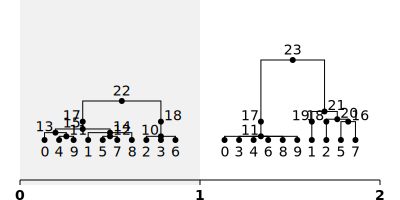

In [3]:
coalesced_ts = msprime.sim_ancestry(
    population_size=N, 
    initial_state=wf_ts, 
    recombination_rate=1 / num_loci, 
    ploidy=1,
    random_seed=7)
SVG(coalesced_ts.draw_svg())

The trees have fully coalesced and we've successfully combined a forwards-time
Wright-Fisher simulation with a coalescent simulation: hooray!


## Why keep input roots (i.e., the initial generation)?

We can now see why it is essential that we take care to preserve the roots of all
trees when we simplified the tree sequence (by passing ``keep_input_roots=True``),
so that the initial generation can be properly used as the
``initial_state`` argument to {func}`msprime.sim_ancestry`. In the example above, if node
``18`` was not in the tree sequence, we would not know that the segment that
node ``10`` inherits from on ``[0.0, 1.0)`` and the segment that node ``2``
inherits from on ``[1.0, 2.0)`` both exist in the same node.

Note that although the portions of intial generation (above, nodes ``16``, ``17``,
``18``, and ``19``) must be in the tree sequence, they do *not* have to be
samples, and their entire genomes need not be represented (e.g., node ``19`` is
only present on ``[1.0, 2.0)``). This allows {func}`msprime.sim_ancestry` to not simulate
the entire history of the first generation, but only what is necessary to complete
any uncoalesced trees. Happily, this is easily done with the ``keep_input_roots`` argument
to {meth}`~tskit.TableCollection.simplify`. Note that this argument would need
to be provided to the periodic {meth}`~tskit.TableCollection.simplify` steps
which are essential in practical simulation, but that we skipped in the toy simulator above.

In fact, this is precisely how tree sequence recording in [SLiM](https://messerlab.org/slim),
works, and {meth}`pyslim.SlimTreeSequence.recapitate` provides a front-end to
the method presented here.


## Topology gotchas

The trees that we output from this combined forwards and backwards simulation
process have some slightly odd properties that are important to be aware of.
In the example above, we can see that the old roots are still present in both trees,
even through they have only one child and are clearly redundant.
This is because the tables of ``initial_state`` have been retained, without modification,
at the top of the tables of the output tree sequence. While this
redundancy is not important for many tasks, there are some cases where
they may cause problems:

1. When computing statistics on the number of nodes, edges or trees in a tree
   sequence, having these unary edges and redundant nodes will slightly
   inflate the values.
2. If you are computing the overall tree "height" by taking the time of the
   root node, you may overestimate the height because there is a unary edge
   above the "real" root (this would happen if one of the trees had already
   coalesced in the forwards-time simulation).

For these reasons it may be better to remove this redundancy from your
computed tree sequence which is easily done using the
{meth}`simplify <tskit.TreeSequence.simplify>` method:

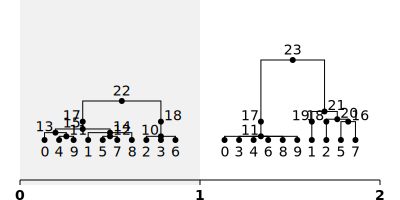

In [4]:
    final_ts = coalesced_ts.simplify()
    SVG(coalesced_ts.draw_svg())

This final tree sequence is topologically identical to the original tree sequence,
but has the redundant nodes and edges removed. Note also that the node IDs have been
reassigned so that the samples are 0 to 9 --- if you need the IDs from the original
tree sequence, please set ``map_nodes=True`` when calling ``simplify`` to get a
mapping between the two sets of IDs.